In [82]:
##Load data
import pandas as pd
import matplotlib.pyplot as plt

#To make table show all columns
pd.set_option('display.max_columns', 50)

file_location = "oral_cancer_prediction_dataset.csv"
dataframe= pd.read_csv(file_location)

dataframe.head()
dataframe.shape

(84922, 25)

In [83]:
##Basic cleaning
##Columns to be dropped
cols_drop= ["Diet (Fruits & Vegetables Intake)", "Unexplained Bleeding", "White or Red Patches in Mouth", "Economic Burden (Lost Workdays per Year)", "Cost of Treatment (USD)"]
dataframe= dataframe.drop(columns=cols_drop)
dataframe.head()

,ID,Country,Age,Gender,Tobacco Use,Alcohol Consumption,HPV Infection,Betel Quid Use,Chronic Sun Exposure,Poor Oral Hygiene,Family History of Cancer,Compromised Immune System,Oral Lesions,Difficulty Swallowing,Tumor Size (cm),Cancer Stage,Treatment Type,"Survival Rate (5-Year, %)",Early Diagnosis,Oral Cancer (Diagnosis)
0,1,Italy,36,Female,Yes,Yes,Yes,No,No,Yes,No,No,No,No,0.000000,0,No Treatment,100.000000,No,No
1,2,Japan,64,Male,Yes,Yes,Yes,No,Yes,Yes,No,No,No,No,1.782186,1,No Treatment,83.340103,No,Yes
2,3,UK,37,Female,No,Yes,No,No,Yes,Yes,No,No,No,No,3.523895,2,Surgery,63.222871,Yes,Yes
3,4,Sri Lanka,55,Male,Yes,Yes,No,Yes,No,Yes,No,No,Yes,No,0.000000,0,No Treatment,100.000000,Yes,No
4,5,South Africa,68,Male,No,No,No,No,No,Yes,No,No,No,No,2.834789,3,No Treatment,44.293199,No,Yes


In [84]:
##standardize column text to simple Yes/No
yes_no_columns= ["Tobacco Use",
    "Alcohol Consumption",
    "HPV Infection",
    "Betel Quid Use",
    "Chronic Sun Exposure",
    "Poor Oral Hygiene",
    "Family History of Cancer",
    "Compromised Immune System",
    "Oral Lesions",
    "Difficulty Swallowing",
    "Early Diagnosis",
    "Oral Cancer (Diagnosis)"
]
for col in yes_no_columns:
    dataframe[col]=dataframe[col].astype(str).str.strip().str.title()


In [85]:
##Convert numeric columns
numeric_columns= ["Tumor Size (cm)", "Survival Rate (5-Year, %)"]
for col in numeric_columns:
    dataframe[col]= pd.to_numeric(dataframe[col], errors='coerce')

##Rounding up the numeric columns
dataframe[numeric_columns]= dataframe[numeric_columns].round(2)
dataframe[numeric_columns].head()

,Tumor Size (cm),"Survival Rate (5-Year, %)"
0,0.00,100.00
1,1.78,83.34
2,3.52,63.22
3,0.00,100.00
4,2.83,44.29


In [86]:
##Creating the region column
dataframe["region"]= dataframe["Country"].apply(lambda x: "US" if x=="USA" else "Global")
dataframe["region"].value_counts()

region
Global    80031
US         4891
Name: count, dtype: int64

In [87]:
##Compare Risk factors:
risk_cols=["Tobacco Use",
    "Alcohol Consumption",
    "Betel Quid Use",
    "HPV Infection",
    "Poor Oral Hygiene",
    "Oral Lesions"
]

##Calculate prevalence
risk_summary= {}

for col in risk_cols:
    prevalence= dataframe.groupby("region")[col].apply(lambda s: (s=="Yes").mean()*100)
    risk_summary[col]= prevalence.round(1)

risk_factors_table= pd.DataFrame(risk_summary).T
risk_factors_table.columns= ["Global (%)", "US (%)"]
risk_factors_table

,Global (%),US (%)
Tobacco Use,80.1,80.0
Alcohol Consumption,60.0,59.8
Betel Quid Use,30.2,9.0
HPV Infection,30.0,28.8
Poor Oral Hygiene,49.8,50.6
Oral Lesions,30.0,30.6


In [88]:
##Compare outcome U.S vs Global
diagnosed= dataframe[dataframe["Oral Cancer (Diagnosis)"]=="Yes"].copy()
diagnosed["region"].value_counts()

#Overall outcome
outcome_summary=diagnosed.groupby("region").agg(number_of_patient=("ID", "count"),
    early_diagnosis=("Early Diagnosis", lambda s: (s == "Yes").mean() * 100),
    mean_tumor_cm=("Tumor Size (cm)", "mean"),
    mean_survival=("Survival Rate (5-Year, %)", "mean")
).round(2)

outcome_summary

,number_of_patient,early_diagnosis,mean_tumor_cm,mean_survival
region,,,,
Global,39902,54.71,3.50,58.87
US,2447,56.27,3.54,59.44


In [89]:
##Finding cancer stage distribution
stage_counts= diagnosed.pivot_table(index="region",
    columns="Cancer Stage",
    values="ID",
    aggfunc="count",
    fill_value=0
)
stage_pct= stage_counts.div(stage_counts.sum(axis=1), axis=0)*100
stage_pct.round(1)


Cancer Stage,1,2,3,4
region,,,,
Global,29.9,30.4,24.9,14.8
US,31.2,30.2,24.5,14.1


In [90]:
#For saving plots as png in folder named 'plots'
import os

#Creating a folder named plots
os.makedirs("plots", exist_ok=True)

#save plots in the folder
def save_plot(filename):
    plt.savefig(os.path.join("plots", filename), bbox_inches='tight')
    print(f"Plot saved as: plots/{filename}")



Plot saved as: plots/risk_factors.png


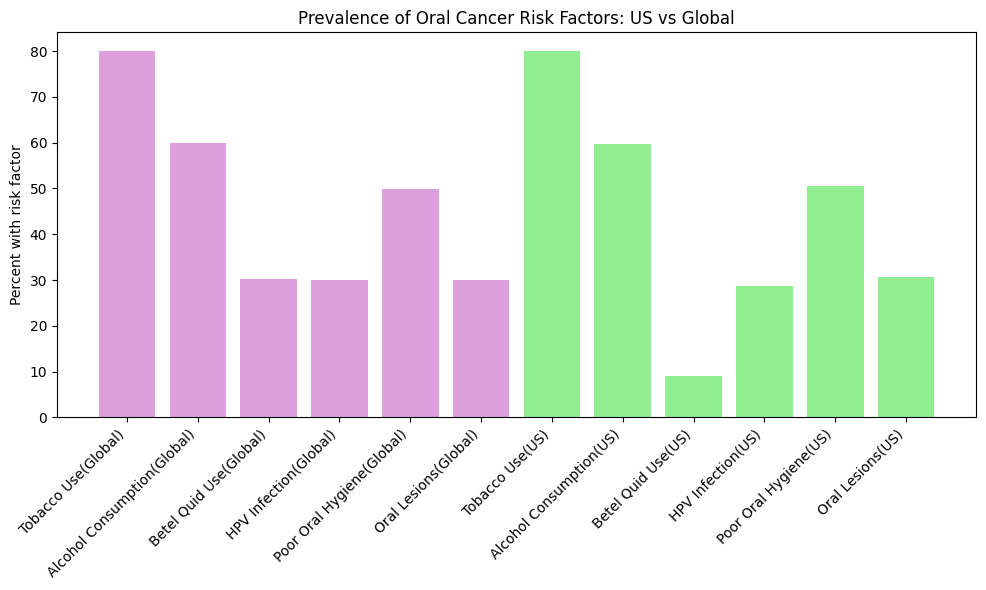

In [91]:
#Creating risk factor visualizations
import matplotlib.pyplot as plt

risk_plot= risk_factors_table.reset_index().melt(
    id_vars="index",
    value_vars=["Global (%)", "US (%)"],
    var_name="Region",
    value_name="Prevalence (%)"
)

risk_plot.rename(columns={"index": "Risk Factor"}, inplace=True)

colors = {
    "Global (%)": "plum",
    "US (%)": "lightgreen"
}

plt.figure(figsize=(10,6))

for region in risk_plot["Region"].unique():
    subset=risk_plot[risk_plot["Region"]==region]
    plt.bar(
        subset["Risk Factor"] + "(" + region.replace(" (%)","") + ")",
        subset["Prevalence (%)"],
        label=region,
        color=colors[region])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Percent with risk factor")
plt.title("Prevalence of Oral Cancer Risk Factors: US vs Global")
plt.tight_layout()

#save as png
save_plot("risk_factors.png")
plt.show()


Plot saved as: plots/outcomes_dashboard.png


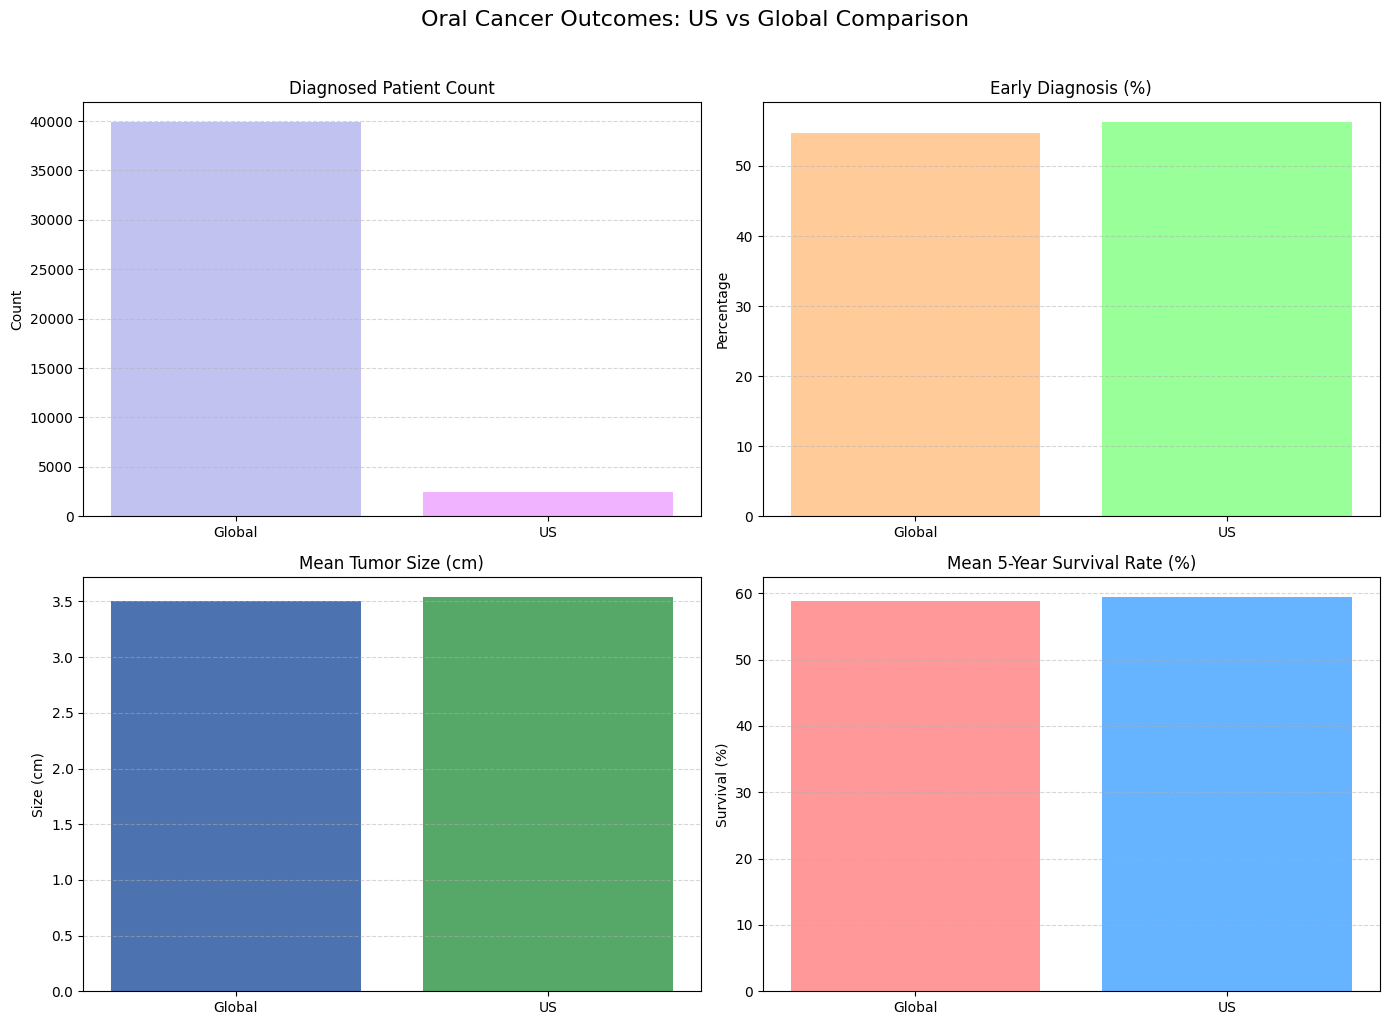

In [95]:
import matplotlib.pyplot as plt

# Extract columns
regions = outcome_summary.index
patients = outcome_summary["number_of_patient"]
early_dx = outcome_summary["early_diagnosis"]
tumor_size = outcome_summary["mean_tumor_cm"]
survival = outcome_summary["mean_survival"]

# Create dashboard layout
plt.figure(figsize=(14,10))

#Chart 1: Number of Patients
plt.subplot(2,2,1)
plt.bar(regions, patients, color=["#c2c2f0", "#f0b3ff"])
plt.title("Diagnosed Patient Count")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.5)

#Chart 2: Early Diagnosis
plt.subplot(2,2,2)
plt.bar(regions, early_dx, color=["#ffcc99", "#99ff99"])
plt.title("Early Diagnosis (%)")
plt.ylabel("Percentage")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Chart 3: Mean Tumor Size
plt.subplot(2,2,3)
plt.bar(regions, tumor_size, color=["#4C72B0", "#55A868"])
plt.title("Mean Tumor Size (cm)")
plt.ylabel("Size (cm)")
plt.grid(axis="y", linestyle="--", alpha=0.5)

#Chart 4: Mean 5-Year Survival
plt.subplot(2,2,4)
plt.bar(regions, survival, color=["#ff9999", "#66b3ff"])
plt.title("Mean 5-Year Survival Rate (%)")
plt.ylabel("Survival (%)")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.suptitle("Oral Cancer Outcomes: US vs Global Comparison", fontsize=16, y=1.02)
plt.tight_layout()

#save as png
save_plot("outcomes_dashboard.png")
plt.show()


Plot saved as: plots/stage_distribution.png


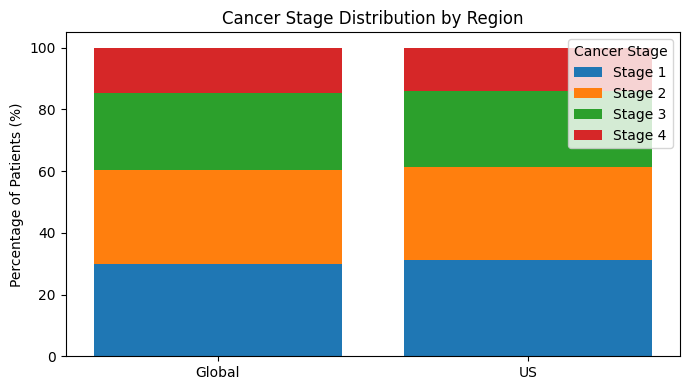

In [93]:
#Creating tumor size and cancer stage visualizations
import matplotlib.pyplot as plt
#cancer stage plot
stage_pct_plot= stage_pct[sorted(stage_pct.columns)]

plt.figure(figsize= (7,4))

bottom=None
for stage in stage_pct_plot.columns:
    if bottom is None:
        plt.bar(stage_pct_plot.index, stage_pct_plot[stage], label= f"Stage {stage}")
        bottom= stage_pct_plot[stage]
    else:
        plt.bar(stage_pct_plot.index, stage_pct_plot[stage], bottom=bottom, label= f"Stage {stage}")
        bottom += stage_pct_plot[stage]
plt.title("Cancer Stage Distribution by Region")
plt.ylabel("Percentage of Patients (%)")
plt.legend(title="Cancer Stage")
plt.tight_layout()  

#save as png
save_plot("stage_distribution.png")
plt.show()

Plot saved as: plots/survival_rate_by_stage.png


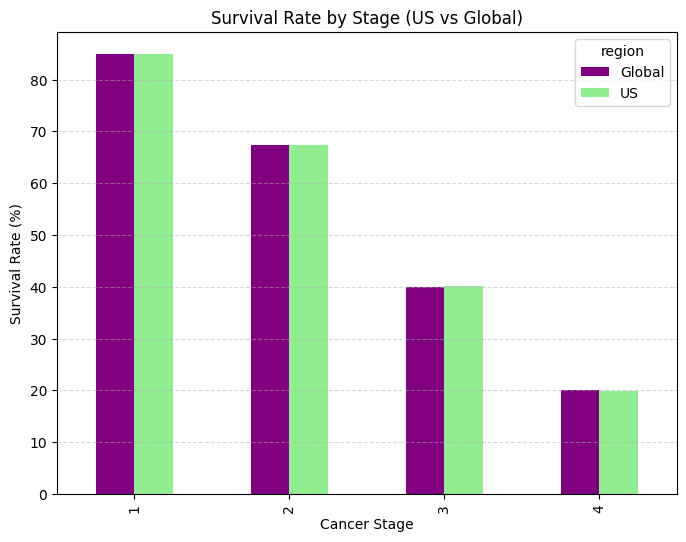

In [94]:
#Creating the survival rate visualization
survival_stage = diagnosed.groupby(["Cancer Stage", "region"])["Survival Rate (5-Year, %)"].mean().reset_index()

pivot = survival_stage.pivot(index="Cancer Stage", columns="region", values="Survival Rate (5-Year, %)")

pivot.plot(kind="bar", figsize=(8,6), color=["purple","lightgreen"])
plt.ylabel("Survival Rate (%)")
plt.title("Survival Rate by Stage (US vs Global)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
#save as png
save_plot("survival_rate_by_stage.png")
plt.show()


